<a href="https://colab.research.google.com/github/BentheBurema/TM10007_ML_Project_group14/blob/main/kopie_nice_roc_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 14 Dataset 2


In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Importing libraries

In [2]:
# Basic packages
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

# Loading dataset
from worcliver.load_data import load_data

# Inspecting dataset
from scipy.stats import kstest

# Splitting dataset
from sklearn import model_selection

# Pre-processing
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import linregress, uniform, skew, kurtosis, norm

# Classifiers
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import tree, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, fbeta_score, classification_report, auc, roc_curve, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tabulate import tabulate


## Inspecting data
In this section the data is inspected by checking the number of samples and features. The balance and distribution of the data is also inspected. Finally the data is checked on None types and NaN values.

In [3]:
def inspecting_data(data):
  '''
  Function to inspect the dataset on number of samples and features. Furthermore
  it checks if there are None types, NaN values and if the dataset is normally
  distributed.

  Input:
    data: dataset you'd like to inspect
  '''
  # Inspecting the data
  print(f'The number of samples: {len(data.index)}')              # print number of samples, features and feature names
  print(f'The number of features: {len(data.columns)}')

  # Check if the dataset is balanced
  malignant = (data['label'] == 'malignant').sum()
  print(f'The percentage of tumors that is malignant is {(malignant/len(data.index))*100}')

  # Check if the data is normally distributed
  Y = data['label']
  X = data.drop('label', axis=1)

  p_values = {}
  for key,values in X.items():

    #perform Kolmogorov-Smirnov test on the values and store the p_values
    _, p_value = kstest(values, 'norm')
    # Store the p-value in the dictionary
    p_values[key] = p_value

  # If p<0.05 the feature is not normally distributed, if p>0.05 the feature is normally distributed
  count_less_than_005 = sum(p_value < 0.05 for p_value in p_values.values())
  count_greater_than_005 = sum(p_value > 0.05 for p_value in p_values.values())

  print(f"Amount of featuers not normally distributed: {count_less_than_005}")
  print(f"Amount of features normally distributed: {count_greater_than_005}")

  # Checking on None types and NaN values
  print(f"Number of None types: {data.isnull().sum().sum()}")     # Count number of None types
  print(f"Number of NaN values: {data.isna().sum().sum()}")       # Count number of NaN values
  return None

## Splitting dataset in training set and test set
In this section the dataset is splitted in training and test set using 20% of the data as test set. This is performed so all the tuning can be performed on only the test set.


In [43]:
def split(data):
  '''
  Function to split the dataset in a train en test set

  Input:
    data: dataset you'd like to split
  Output:
    x_train: a dataframe containing samples of the train set
    x_test: a dataframe containing samples of the train set
    y_train: labels of the train set
    y_test: labels of the test set
  '''
  y = data['label']
  x = data.drop('label', axis=1)

  # Split the dataset in training and test part
  x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)

  # Check if this is executed correctly
  print("Amount samples in X_train (X_train):", x_train.shape[0])
  print("Amount samples in X_test  (X_test):", x_test.shape[0])
  print("Amount samples in Y_train (Y_train):", y_train.shape[0])
  print("Amount samples in Y_test (Y_test):", y_test.shape[0])

  display(x_train.head())

  # Transform datasets to dataframes
  x_train = pd.DataFrame(x_train)
  x_test = pd.DataFrame(x_test)
  return x_train, x_test, y_train, y_test

## Preprocessing

### Delete features with more than 50% zeros

In [76]:
def delete_zeros(X_dataset):
  '''
  Function to delete features with more than 50% zeros.

  Input:
    X_dataset: this can be the train or test set of samples
  Output:
    X_dataset: adjusted train or test set without features with more than
    50% zeros
  '''
  for column in X_dataset.columns:
    # Count amount of zeros in each column
    num_zeros = X_dataset[column].isin([0]).sum()

    # Calculate percentage of zeros in each column
    percentage_zeros = (num_zeros / len(X_dataset.index)) * 100

    # Check if there are more than 50% zeros in a column
    if percentage_zeros > 50:
        # Delete the column
        X_dataset.drop(column, axis=1, inplace=True)

  # Print the data shape before and after deleting features with >50% zeros
  print(f'The data shape after deleting features with >50% zeros: {X_dataset.shape}')
  return X_dataset

def checking_zeros_after_deleting(X_dataset_deleted_zeros):
  '''
  Function to check how many zeros are still present in the dataset after
  deleting features with more than 50% zeros.

  Input:
    X_dataset_deleted_zeros: adjusted train or test set without features with
    more than 50% zeros
  '''
  total_num_zeros = 0
  for column in X_dataset_deleted_zeros.columns:
    num_zeros = X_dataset_deleted_zeros[column].isin([0]).sum()
    total_num_zeros += num_zeros
  print(f"Total number of zeros in the dataset after deleting features with >50% zeros: {total_num_zeros}")
  return None

### Outliers
In this section the data is checked on outliers. A value is called an outlier based on the interquartile range.

In [77]:
def define_outliers(X_dataset):
    '''
    Function to determine the amount of outliers in the dataset.

    Input:
      X_dataset: adjusted train or test set without features with more than 50% zeros
    Output:
      outliers_total: total amount of outliers in the dataset
    '''
    outliers_total = 0
    for column in X_dataset.columns:
        sorted_feature = np.sort(X_dataset[column])  # Sort the values of the column
        Q1 = np.percentile(sorted_feature, 25)
        Q3 = np.percentile(sorted_feature, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        outliers_total_column = ((sorted_feature < lower_bound) | (sorted_feature > upper_bound)).sum()
        outliers_total += outliers_total_column
    return outliers_total

### RobustScaling
In this section the dataset is robustly scaled because there are outliers and the features are not normally distributed.


In [78]:
def scaling(X_dataset):
  '''
  Function to scale the dataset using a RobustScaler.

  Input:
    X_dataset: adjusted train or test set without features with more than 50% zeros
  Output:
    X_dataset_scaled: scaled train or test set
  '''
  scaler = RobustScaler(quantile_range=(0.1, 0.9)).fit(X_dataset) # first and last 10% of samples are seen as outliers
  scaler.fit(X_dataset)
  X_dataset_scaled = scaler.transform(X_dataset)
  X_dataset_scaled = pd.DataFrame(data=X_dataset_scaled, columns=X_dataset.columns)
  return X_dataset_scaled

### Remove zero variance
In this section features with zero variance are removed, because these are of no value in distinguishing between benign and malignant.

In [79]:
def zero_variance(X_dataset_scaled):
  '''
  Function to delete features with zero variance.

  Input:
    X_dataset_scaled: scaled train set
  Output:
    X_dataset_var: scaled train set without features with zero variance
  '''
  # Remove features with zero variance
  vt = VarianceThreshold(threshold=0.0)
  X_dataset_var = vt.fit_transform(X_dataset_scaled)
  # Select the right columns from X_dataset_scaled
  selected_columns = X_dataset_scaled.columns[vt.get_support()]

  # Create a dataframe for X_dataset_var with only the selected columns
  X_dataset_var = pd.DataFrame(X_dataset_var, columns=selected_columns)
  print(f'The data shape before removing zero variance: {X_dataset_scaled.shape} and after: {X_dataset_var.shape}')
  return X_dataset_var

### ANOVA test
In this section the ANOVA test is performed on the dataset. Features are selected if there is a p-value smaller than 0.05.

In [80]:
def anova_analysis(X_dataset_var, Y_dataset):
  '''
  Function to perform ANOVA test. ANOVA feature selection for numeric input and
  categorical output.

  Input:
    X_dataset_var: scaled train set without features with zero variance
    Y_dataset: labels of the train set
  Output:
    X_dataset_anova: a dataframe of the train set with only the selected features
    after ANOVA
  '''
  # Define feature selection
  fs = SelectKBest(score_func=f_classif, k='all')

  # Apply feature selection
  X_dataset_anova = fs.fit_transform(X_dataset_var, Y_dataset)
  X_dataset_anova = pd.DataFrame(data=X_dataset_anova, columns=X_dataset_var.columns)
  feature_scores = list(zip(fs.pvalues_, X_dataset_anova.columns))

  # Select the features with p<0.05, because only than benign is significantly different from malignant
  selected_features = [feature[1] for feature in feature_scores if feature[0] < 0.05]

  # Create a dataframe for X_dataset_anova with only the selected features
  X_dataset_anova = X_dataset_anova[selected_features]
  print(f'The data shape before ANOVA: {X_dataset_var.shape} and after ANOVA: {X_dataset_anova.shape}')
  return X_dataset_anova

### RFECV
In this section the Recursive feature elimination with cross-validation is performed to select the final features. As a classifier a support vector with a linear kernel is used.

In [81]:
def function_calc_RFECV(X_dataset_anova, Y_dataset): # x_train_anova must be used as an argument here.
    '''
    Function to perform the final feature selection using RFECV.

    Input:
      X_dataset_anova: a dataframe of the train set with only the selected features
      after ANOVA
      Y_dataset: labels of the train set
    Output:
      X_rfecv: a dataframe of the train set with only the selected features
      after RFECV
      selected_column_names: names of the features which have been selected
      by RFECV
    '''
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y_dataset)

    clf = SVC(kernel='linear',random_state=0)

    min_features_to_select = 1
    rfecv = RFECV(estimator=clf,
                  step=5,
                  cv=cv,
                  scoring='roc_auc',
                  min_features_to_select=min_features_to_select
                  )
    rfecv.fit(X_dataset_anova, Y_encoded)
    print(f'Optimal number of features: {rfecv.n_features_}')

    X_rfecv = rfecv.transform(X_dataset_anova)

    # Get the selected feature indices
    selected_features_indices = rfecv.get_support()

    X_dataset_anova = pd.DataFrame(X_dataset_anova)

    # Get the names of the selected features
    selected_column_names = X_dataset_anova.columns[selected_features_indices]

    print(f'The data shape before RFECV: {X_dataset_anova.shape} and after RFECV: {X_rfecv.shape}')
    return X_rfecv, selected_column_names

## Classifiers

### Label encoder which will be used in the classifiers
In this section the labels are converted into zeros and ones, so it is numerical data.

In [50]:
def label_encoder(Y_dataset):
  '''
  Function to initialize label encoder.

  Input:
    Y_dataset: labels of the train set
  Output:
    Y_dataset_encoded: labels of the train set converted to zeros and ones.
    0 = benigne, 1 = malignant
  '''
  label_encoder = LabelEncoder()

  # Apply label encoder on Y_train to transform categorical input to numeric input. Malignant = 1, benigne = 0
  Y_dataset_encoded = label_encoder.fit_transform(Y_dataset)

  # Define the coded classes
  print("Coded classes:", label_encoder.classes_)
  return Y_dataset_encoded

### K-NN
In this section the k-nearest neighbour classifier is created.

In [71]:
def KNN(X_dataset_rfecv, Y_dataset_encoded):
  '''
  Function to create and fit the KNN-classifier. Finally, the best performing
  parameters and classifier is selected.

  Input:
    X_dataset_rfecv: a dataframe of the train set with only the selected features
    after RFECV
    Y_dataset_encoded: labels of the train set converted to zeros and ones.
    0 = benigne, 1 = malignant
  Output:
    knn_classifier: the best performing KNN-classifier
  '''
  # Define a parameter grid for RandomizedSearchCV
  parameter_grid = {'n_neighbors': list(range(10, 40)),
                    'weights': ['uniform','distance'],
                    'p': [1,2],
                    'algorithm': ['ball_tree','kd_tree','brute','auto'],
                    'leaf_size': [30]
                    }

  # Create a RandomizedSearchCV and apply it to the dataset with crossvalidation
  rscv_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=parameter_grid, n_iter=40, cv=cv, random_state=0, scoring=f2_scorer)

  # Fit the classifier
  rscv_knn.fit(X_dataset_rfecv, Y_dataset_encoded)

  # Extract the best parameters and show the F2-score
  print('Best parameters found for KNN-classifier:', rscv_knn.best_params_)
  print('Best F2-score found for KNN-classifier:', rscv_knn.best_score_)

  # Fit the classifier with the best parameters on the dataset
  knn_classifier = rscv_knn.best_estimator_
  knn_classifier.fit(X_dataset_rfecv, Y_dataset_encoded)
  return knn_classifier

### Decision Tree Classifier
In this section the decision tree classifier is created.

In [72]:
def DTC(X_dataset_rfecv, Y_dataset_encoded):
  '''
  Function to create and fit the decision tree classifier. Finally, the best
  performing parameters and classifier is selected.

  Input:
    X_dataset_rfecv: a dataframe of the train set with only the selected features
    after RFECV
    Y_dataset_encoded: labels of the train set converted to zeros and ones.
    0 = benigne, 1 = malignant
  Output:
    dtc_classifier: the best performing decision tree classifier
  '''

  # Define a parameter grid for RandomizedSearchCV
  parameter_grid = {"max_depth": np.arange(3,10,1),
                    "min_samples_split": np.arange(10,30,2),
                    'min_samples_leaf': np.arange(10,30,2),
                    "criterion": ['gini', 'entropy', 'log_loss'],
                    "splitter": ['best'],
                    }

  # Create a RandomizedSearchCV and apply it to the dataset with crossvalidation
  rscv_dtc = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distributions=parameter_grid, refit=True, verbose=1, scoring=f2_scorer, cv=cv, random_state=0, n_iter=30)

  # Fit the classifier
  rscv_dtc.fit(X_dataset_rfecv, Y_dataset_encoded)

  # Extract the best parameters and show the F2-score
  print('Best parameters found for decision tree classifier:', rscv_dtc.best_params_)
  print('Best F2-score found for decision tree classifier:', rscv_dtc.best_score_)

  # Fit the classifier with the best parameters on the dataset
  dtc_classifier = rscv_dtc.best_estimator_
  dtc_classifier.fit(X_dataset_rfecv, Y_dataset_encoded)
  return dtc_classifier

### RandomForest Classifier
In this section the random forest classifier is created.

In [73]:
def RFC(X_dataset_rfecv, Y_dataset_encoded):
  '''
  Function to create and fit the random forest classifier. Finally, the best
  performing parameters and classifier is selected.

  Input:
    X_dataset_rfecv: a dataframe of the train set with only the selected features
    after RFECV
    Y_dataset_encoded: labels of the train set converted to zeros and ones.
    0 = benigne, 1 = malignant
  Output:
    rf_classifier: the best performing random forest classifier
  '''
  parameter_grid = {'n_estimators': np.arange(25, 100, 5),
                  'max_depth': np.arange(3, 7),
                  'max_leaf_nodes': np.arange(2, 8),
                  'min_samples_leaf': np.arange(5, 10)
                 }

  # Create a RandomizedSearchCV and apply it to the dataset with crossvalidation
  rscv_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=parameter_grid, cv=cv, n_iter=20, scoring=f2_scorer, random_state=0)

  # Fit the classifier
  rscv_rf.fit(X_dataset_rfecv, Y_dataset_encoded)

  # Extract the best parameters and show the F2-score
  print('Best parameters found for random forest classifier:', rscv_rf.best_params_)
  print('Best F2-score found for random forest classifier:', rscv_rf.best_score_)

  # Fit the classifier with the best parameters on the dataset
  rf_classifier = rscv_rf.best_estimator_
  rf_classifier.fit(X_dataset_rfecv, Y_dataset_encoded)
  return rf_classifier

### SVM
In this section the support vector classifier is created.

In [74]:
def SVM(X_dataset_rfecv, Y_dataset_encoded):
  '''
  Function to create and fit the support vector machine classifier. Finally,
  the best performing parameters and classifier is selected.

  Input:
    X_dataset_rfecv: a dataframe of the train set with only the selected features
    after RFECV
    Y_dataset_encoded: labels of the train set converted to zeros and ones.
    0 = benigne, 1 = malignant
  Output:
    svm_classifier: the best performing support vector machine classifier
  '''

  # Define a parameter grid for RandomizedSearchCV
  parameter_grid = {'C': np.logspace(-3, 1, 5),  # Probeer kleinere waarden voor C
                  'kernel': ['linear'],  # Gebruik een lineaire kernel
                  'probability': [True]
                  }

  # Create a RandomizedSearchCV and apply it to the dataset with crossvalidation
  rscv_svm = RandomizedSearchCV(SVC(), param_distributions=parameter_grid, n_iter=20, cv=cv, scoring=f2_scorer, random_state=0)

  # Fit the classifier
  rscv_svm.fit(X_dataset_rfecv, Y_dataset_encoded)

  # Extract the best parameters and show the F2-score
  print('Best parameters found for SVM classifier:', rscv_svm.best_params_)
  print('Best F2-score found for SVM classifier:', rscv_svm.best_score_)

  # Fit the classifier with the best parameters on the dataset
  svm_classifier = rscv_svm.best_estimator_
  svm_classifier.fit(X_train_rfecv, Y_train_encoded)
  return svm_classifier

### Ensembling
In this function the voting classifier is created. In this classifier only the three best performing classifiers are used.

In [75]:
def voting(X_dataset_rfecv, Y_dataset):
  '''
  Function to create and fit voting classifier.

  Input:
    X_dataset_rfecv: a dataframe of the train set with only the selected features
    after RFECV
    Y_dataset_encoded: labels of the train set converted to zeros and ones.
    0 = benigne, 1 = malignant
  Output:
    voting: the voting classifier
  '''

  voting = VotingClassifier(estimators=[
  ('knn', KNN_classifier),
  ('rf', RF_classifier),
  ('svm', SVM_classifier)],
  voting='soft')

  # Train de voting classifier
  voting.fit(X_dataset_rfecv, Y_dataset)
  return voting

## Checking performance

### Learning curves
In this section a function to plot a learning curve is created, so you can see the training and validation performance while increasing the train size.

In [56]:
def plot_learning_curve(estimator, title, X_dataset_rfecv, Y_dataset_encoded, cv=None, train_sizes=np.linspace(.1, 1.0, 10)):
    '''
    Function to plot a learning curve.

    Input:
      estimator: classifier of which you'd like to see the learning curve
      title: title of the figure
      X_dataset_rfecv: a dataframe of the train or test set with only the selected features
      after RFECV
      Y_dataset_encoded: labels of the train set converted to zeros and ones.
      0 = benigne, 1 = malignant
      cv: type of cross-validation
    Output:
      plt: figure
    '''
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Number of training examples")
    plt.ylabel("F2-score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_dataset_rfecv, Y_dataset_encoded, cv=cv, scoring=f2_scorer, train_sizes=train_sizes, n_jobs=-1, random_state=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training F2-score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation F2-score")

    plt.legend(loc="best")
    return plt

### Calculating metrics
In this section various metrics are calculated and showed in a table.


In [57]:
def metrics(classifiers, X_dataset_rfecv, Y_dataset):
  '''
  Function to calculate the metrics of the classifiers and show these in a table.

  Input:
    classifiers: classifiers of which you'd like to see the metrics
    X_dataset_rfecv: a dataframe of the train or test set with only the selected features
    after RFECV
    Y_dataset: labels
  '''
  results = {'Metrics': ['Accuracy', 'Precision', 'Recall', 'F2 score', 'ROC AUC']}

  # Loop through best fitted classifiers, perform cross_validation and calculate the mean scores
  for clf in classifiers:
    accuracy = cross_val_score(clf, X_dataset_rfecv, Y_dataset, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(clf, X_dataset_rfecv, Y_dataset, cv=cv, scoring='precision_macro').mean()
    recall = cross_val_score(clf, X_dataset_rfecv, Y_dataset, cv=cv, scoring='recall_macro').mean()
    f2_score = cross_val_score(clf, X_dataset_rfecv, Y_dataset, cv=cv, scoring=f2_scorer).mean()
    roc_auc = cross_val_score(clf, X_dataset_rfecv, Y_dataset, cv=cv, scoring='roc_auc').mean()

    # Add classifier names to the table
    clf_name = clf.__class__.__name__
    results[clf_name] = [accuracy, precision, recall, f2_score, roc_auc]

  # Create a dataframe of the results
  results_df = pd.DataFrame(results)

  # Transpose dataframe
  results_df.set_index('Metrics', inplace=True)
  results_df = results_df.T

  # Print table
  print(tabulate(results_df, headers='keys', tablefmt='pretty'))
  return None

### ROC curve
In this section the Receiver operating characteristic curve is created to eventually test the performance of the best classifier on the test set.

In [58]:
def plot_roc_curve(y_pred, y_truth):
    '''
    Function to plot an ROC curve.

    Input:
      y_pred: list of the predicted labels
      y_truth: list of the true labels
    '''

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    return None

### Confusion matrix
In this section a confusion matrix is created to eventually test the performance of the best classifier on the test set. In this confusion matrix you could see the true/false positives/negatives.

In [59]:
def determine_confusion_matrix(y_truth, y_pred):
    '''
    Function to create a confusion matrix.

    Input:
      y_truth: list of the true labels
      y_pred: list of the predicted labels
    '''
    cm = confusion_matrix(y_truth, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigne', 'Malignant'])
    cm_display.plot()
    plt.title('Confusion matrix')
    plt.show()
    return None

## Performing global functions on dataset

In [60]:
# Loading data
data = load_data()

# Inspecting data
inspecting_data(data)

# Splitting dataset
X_train, X_test, Y_train, Y_test = split(data)

The number of samples: 186
The number of features: 494
The percentage of tumors that is malignant is 50.53763440860215
Amount of featuers not normally distributed: 493
Amount of features normally distributed: 0
Number of None types: 0
Number of NaN values: 0
Amount samples in X_train (X_train): 148
Amount samples in X_test  (X_test): 38
Amount samples in Y_train (Y_train): 148
Amount samples in Y_test (Y_test): 38


,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,PREDICT_original_sf_cvar_avg_2.5D,PREDICT_original_sf_cvar_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
ID,,,,,,,,,,,,,,,,,,,,,
Liver-149_0,0.824583,0.055989,30.099345,4.415992,3.661071,1.861613,0.963279,0.022393,0.021571,0.011780,...,0.000000,0.104107,2.756906,8.453818,0.0,0,0.409805,222.558113,0.042636,11.809102
Liver-132_0,0.801146,0.092439,62.217271,5.375470,6.822246,2.509137,0.924549,0.049767,0.007751,0.002992,...,0.000000,0.100082,3.289330,11.458823,0.0,0,0.412003,2198.965478,0.000000,14.737962
Liver-018_0,0.784347,0.051682,29.057589,5.423131,8.776120,6.493751,0.967914,0.015269,0.035515,0.011933,...,0.015554,0.152348,1.301602,0.810392,0.0,0,0.526233,678.343564,0.211135,12.903202
Liver-135_0,0.762971,0.071214,39.719594,6.220513,8.349609,4.035151,0.944998,0.031507,0.028765,0.017286,...,0.000000,0.108344,1.929157,3.090863,0.0,0,0.391573,1168.726859,0.088960,14.316269
Liver-015_0,0.836579,0.075738,61.507831,7.303462,11.104662,3.733124,0.952526,0.027722,0.016664,0.011443,...,0.000000,0.078725,3.747019,15.215261,0.0,0,0.332604,1306.631943,0.000000,14.384808


## Performing functions on training set

In [83]:
# Creating way of scoring
f2_scorer = make_scorer(fbeta_score, beta=2)
# Initializing cross-validation
cv = StratifiedKFold(n_splits=5)

# Pre-processing
X_train = delete_zeros(X_train)
checking_zeros_after_deleting(X_train)
outliers_total = define_outliers(X_train)
print(f'In total there are {outliers_total} outliers')
X_train_scaled = scaling(X_train)
X_train_var = zero_variance(X_train_scaled)
X_train_anova = anova_analysis(X_train_var, Y_train)
X_train_rfecv, feature_names = function_calc_RFECV(X_train_anova,Y_train)
Y_train_encoded = label_encoder(Y_train)

# Classifiers
KNN_classifier = KNN(X_train_rfecv, Y_train_encoded)
DTC_classifier = DTC(X_train_rfecv, Y_train_encoded)
RF_classifier = RFC(X_train_rfecv, Y_train_encoded)
SVM_classifier = SVM(X_train_rfecv, Y_train_encoded)
voting_classifier = voting(X_train_rfecv, Y_train_encoded)

# Learning curves
# Create a list with all the classifiers
classifiers = {'Decision tree classifier': DTC_classifier, 'K-NN classifier': KNN_classifier, 'Random forest classifier': RF_classifier,
               'SVM classifier': SVM_classifier, 'Ensembling through voting': voting_classifier}

# Plot the learning curve for each classifier
for name, clf in classifiers.items():
  title = f"Learning Curves ({name})"
  plot_learning_curve(clf, title, X_train_rfecv, Y_train_encoded, cv=cv)
  plt.show()

# Create a table with all the metrics of the classifiers performed on the training set
metrics([KNN_classifier, DTC_classifier, RF_classifier, SVM_classifier, voting_classifier], X_train_rfecv, Y_train_encoded)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

## Performing functions on test set

Coded classes: ['benign' 'malignant']
+------------------+--------------------+-----------+--------+--------------------+--------------------+
|                  |      Accuracy      | Precision | Recall |      F2 score      |      ROC AUC       |
+------------------+--------------------+-----------+--------+--------------------+--------------------+
| VotingClassifier | 0.7357142857142858 |   0.805   |  0.8   | 0.7391806722689076 | 0.8583333333333332 |
+------------------+--------------------+-----------+--------+--------------------+--------------------+


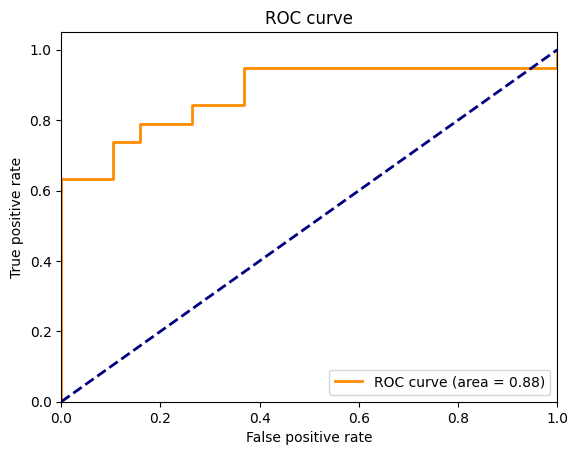

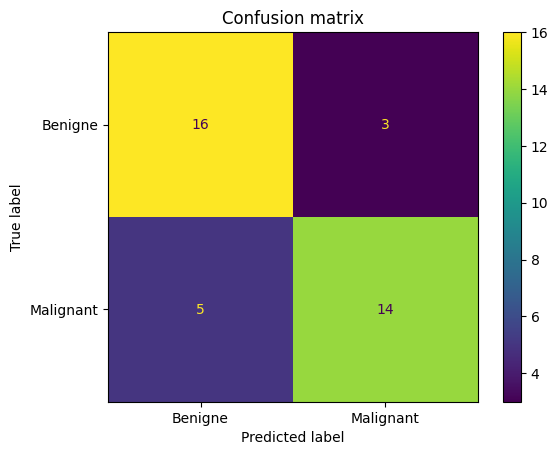

In [63]:
# Creating way of scoring
f2_scorer = make_scorer(fbeta_score, beta=2)
# Initializing cross-validation
cv = StratifiedKFold(n_splits=5)

# Pre-processing on test set
X_test_scaled = scaling(X_test)
Y_test_encoded = label_encoder(Y_test)

# Select the right columns based on the selected columns in the pre-processing of the train set
X_test_useful_features = X_test_scaled[feature_names]

# Create a table with all the metrics of the classifiers performed on the training set
clf = [voting_classifier]
metrics(clf, X_test_useful_features, Y_test_encoded)

# ROC curve plotten
Y_pred_roc = voting_classifier.predict_proba(X_test_useful_features)[:,1]
plot_roc_curve(Y_pred_roc, Y_test_encoded)

# Creating a confusion matrix
Y_pred_cm = voting_classifier.predict(X_test_useful_features)
determine_confusion_matrix(Y_test_encoded, Y_pred_cm)